In [2]:
import joblib
import pandas as pd
import os

df = pd.read_csv("../data/processed/dataset_entrenamiento_final_final.csv")
df.head()

target = "conteo_delitos" # columna objetivo
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("RMSE:", rmse)

# GUARDAR EL MODELO
os.makedirs("../models/trained", exist_ok=True)
joblib.dump(model, "../models/trained/modelo_riesgo_delictivo.pkl")




RMSE: 0.32505139898126156


['../models/trained/modelo_riesgo_delictivo.pkl']

Modelo cargado correctamente.

IMPORTANCIA DE VARIABLES (GAIN)
                  feature  importance
5   conteo_delitos_graves  403.398895
6  conteo_llamadas_riesgo   89.039856
0                lat_grid   21.086567
4              dia_semana   19.338385
3                     dia   18.905947
1                lon_grid   13.401047
2                     mes   12.823771


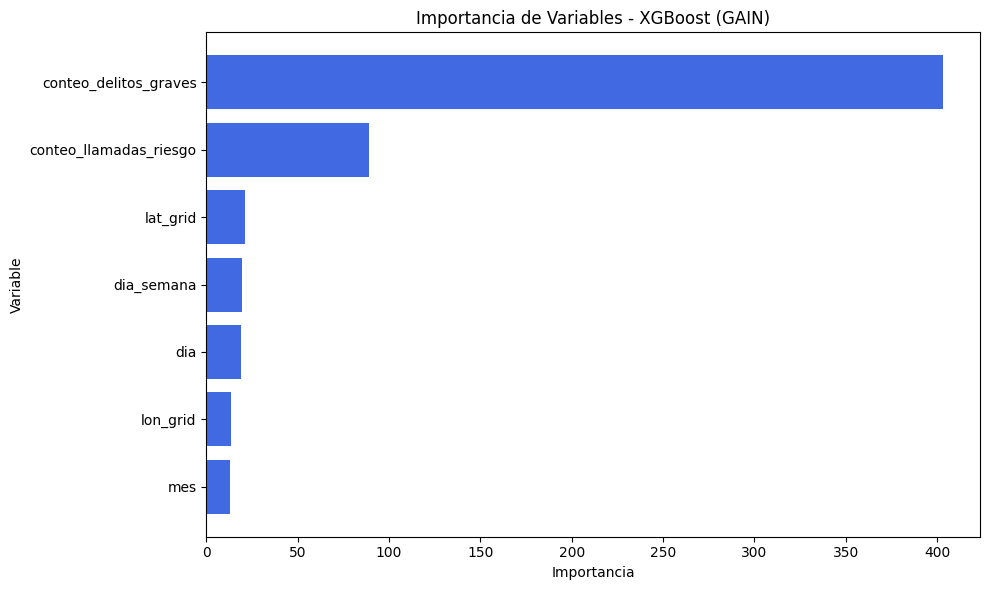

In [3]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. CARGAR EL MODELO ENTRENADO DESDE ARCHIVO
# ============================================================

modelo = joblib.load("../models/trained/modelo_riesgo_delictivo.pkl")

print("Modelo cargado correctamente.")

# ============================================================
# 2. OBTENER IMPORTANCIA DE VARIABLES (XGBoost GAIN)
# ============================================================

booster = modelo.get_booster()
importance = booster.get_score(importance_type='gain')

df_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

df_importance = df_importance.sort_values(by='importance', ascending=False)

print("\n==============================")
print("IMPORTANCIA DE VARIABLES (GAIN)")
print("==============================")
print(df_importance)

# ============================================================
# 3. GRAFICAR IMPORTANCIA DE VARIABLES
# ============================================================

plt.figure(figsize=(10, 6))
plt.barh(df_importance["feature"], df_importance["importance"], color="royalblue")
plt.gca().invert_yaxis()
plt.title("Importancia de Variables - XGBoost (GAIN)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

In [7]:

# ---------------------------
# Utilidades
# ---------------------------
def _safe_predict_proba(model, X):
    """Devuelve probas de clase positiva si existe predict_proba; si no, intenta decision_function."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        # binario: (n,2) -> columna 1
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        # ya viene como (n,)
        return proba
    raise ValueError("El modelo no tiene predict_proba(). Para clasificación, usa XGBClassifier.")

def _plot_curve(x, y, xlabel, ylabel, title):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

def buscar_threshold_por_recall(model, X_val, y_val, recall_objetivo=0.90):
    """
    Busca un threshold que logre al menos recall_objetivo en val (si es posible),
    priorizando el threshold más alto (menos agresivo) que cumpla el objetivo.
    """
    p = _safe_predict_proba(model, X_val)

    # thresholds candidatos: percentiles -> rápido y suficiente
    candidatos = np.unique(np.quantile(p, np.linspace(0, 1, 200)))
    candidatos = np.clip(candidatos, 0, 1)

    mejor = None
    for thr in sorted(candidatos, reverse=True):
        yhat = (p >= thr).astype(int)
        cm = confusion_matrix(y_val, yhat, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        alert_rate = yhat.mean()
        if recall >= recall_objetivo:
            mejor = (thr, recall, precision, alert_rate, cm)
            break

    if mejor is None:
        # Si no se llega al recall objetivo, devuelve el mejor recall posible (thr bajo)
        best_recall = -1
        best = None
        for thr in sorted(candidatos):
            yhat = (p >= thr).astype(int)
            cm = confusion_matrix(y_val, yhat, labels=[0,1])
            tn, fp, fn, tp = cm.ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            alert_rate = yhat.mean()
            if recall > best_recall:
                best_recall = recall
                best = (thr, recall, precision, alert_rate, cm)
        thr, recall, precision, alert_rate, cm = best
        print(f"No se alcanzó recall objetivo={recall_objetivo:.2f}. Mejor recall={recall:.4f} con thr={thr:.6f}")
        return {"threshold": thr, "recall": recall, "precision": precision, "alert_rate": alert_rate, "confusion": cm}

    thr, recall, precision, alert_rate, cm = mejor
    print(f"Threshold encontrado thr={thr:.6f} | recall={recall:.4f} | precision={precision:.4f} | alert_rate={alert_rate:.4f}")
    return {"threshold": thr, "recall": recall, "precision": precision, "alert_rate": alert_rate, "confusion": cm}


# ---------------------------
# Evaluación: Regresión
# ---------------------------
def evaluar_regresion(
    model,
    X_train, y_train,
    X_val, y_val,
    titulo="Modelo Regresión"
):
    """
    Evaluación:
    - MAE, RMSE, R2 (train/val)
    - Gráfico pred vs real (val)
    - Residuales (val)
    """
    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_val)

    mae_tr = mean_absolute_error(y_train, pred_tr)
    mae_va = mean_absolute_error(y_val, pred_va)

    rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
    rmse_va = np.sqrt(mean_squared_error(y_val, pred_va))

    r2_tr = r2_score(y_train, pred_tr)
    r2_va = r2_score(y_val, pred_va)

    print("="*70)
    print(titulo)
    print("-"*70)
    print(f"MAE   train={mae_tr:.4f} | val={mae_va:.4f}")
    print(f"RMSE  train={rmse_tr:.4f} | val={rmse_va:.4f}")
    print(f"R2    train={r2_tr:.4f} | val={r2_va:.4f}")
    print("="*70)

    # Pred vs Real (val)
    plt.figure()
    plt.scatter(y_val, pred_va, s=10)
    minv = float(min(y_val.min(), pred_va.min()))
    maxv = float(max(y_val.max(), pred_va.max()))
    plt.plot([minv, maxv], [minv, maxv], linestyle="--")
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title("Predicho vs Real (val)")
    plt.grid(True)
    plt.show()

    # Residuales (val)
    resid = y_val - pred_va
    plt.figure()
    plt.scatter(pred_va, resid, s=10)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicho")
    plt.ylabel("Residual (real - predicho)")
    plt.title("Residuales (val)")
    plt.grid(True)
    plt.show()

    return {
        "mae_train": mae_tr, "mae_val": mae_va,
        "rmse_train": rmse_tr, "rmse_val": rmse_va,
        "r2_train": r2_tr, "r2_val": r2_va,
    }

Modelo Regresión
----------------------------------------------------------------------
MAE   train=0.1030 | val=0.1040
RMSE  train=0.3070 | val=0.3107
R2    train=0.9662 | val=0.9656


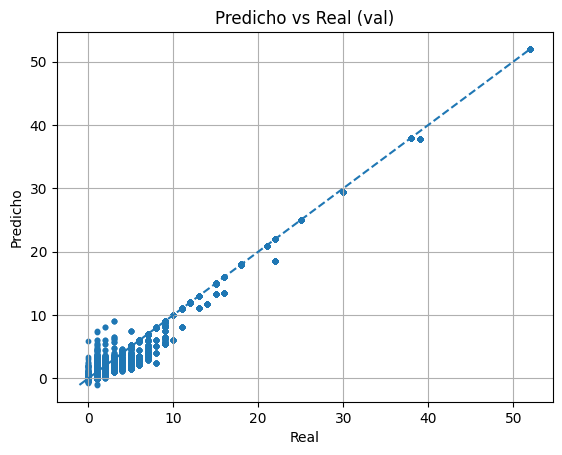

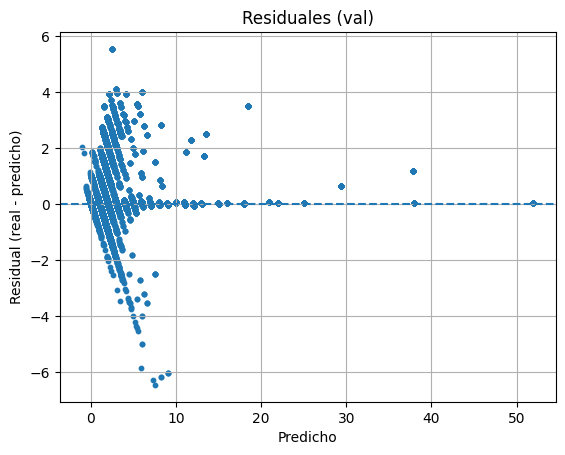

{'mae_train': 0.10298176854848862, 'mae_val': 0.10402995347976685, 'rmse_train': np.float64(0.3070375097282156), 'rmse_val': np.float64(0.31072390806475997), 'r2_train': 0.9662366509437561, 'r2_val': 0.9655539989471436}


In [8]:
metrics_reg = evaluar_regresion(modelo, X_train, y_train, X, y)

print(metrics_reg)